# Yelp Review Predictor

### Author: Lisa Huang, Huihan Li, Mara-Florina Steiu
Created: 05/03/2018
Last Modified: 05/20/2018

Features used: number of exclamations, number of punctuations, rating difference between actual and overall, positive sentiment words, negative sentiment words

Accuracy: **61.61%**

**CS232 Final Project of *Huihan Li, Lisa Huang and Mara-Florina Steiu* **

# 1. Analyzing the data

## 1.1 Open json data

In [1]:
import json

In [2]:
from open_useful_reviews import *
from open_useless_reviews import *
from open_business import *

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# A review with "useful" votes
useful[0]

{'business_id': '5r6-G9C4YLbC7Ziz57l3rQ',
 'character count': 244,
 'cool': 0,
 'date': '2013-02-09',
 'funny': 0,
 'review_id': 'w41ZS9shepfO3uEyhXEWuQ',
 'stars': 3,
 'text': "Not bad!! Love that there is a gluten-free, vegan version of the cheese curds and gravy!!\n\nHaven't done the poutine taste test yet with smoke's but Im excited to see which is better. However poutini's might win as they are vegan and gluten-free",
 'useful': 1,
 'user_id': 'u0LXt3Uea_GidxRW1xcsfg'}

In [5]:
# A review with 0 "useful" votes
useless[0]

{'business_id': '0W4lkclzZThpx3V65bVgig',
 'character count': 289,
 'cool': 0,
 'date': '2016-05-28',
 'funny': 0,
 'review_id': 'v0i_UHJMo_hPBq9bxWvW4w',
 'stars': 5,
 'text': "Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.",
 'useful': 0,
 'user_id': 'bv2nCi5Qv5vroFiqKGopiw'}

## 1.2 Find the distribution of "useful" votes


In [6]:
distribution = {}
for d in useful:
    if d["useful"] not in distribution:
        distribution[d["useful"]] = 1
    else:
        distribution[d["useful"]] += 1

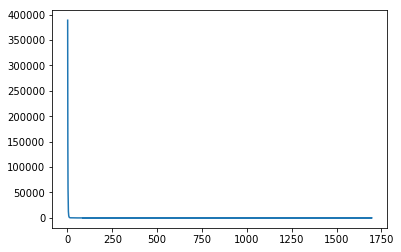

In [7]:
pairs = distribution.items()
X = [t[0] for t in pairs]
Y = [t[1] for t in pairs]
position = range(len(pairs))

plt.plot(X, Y)
plt.show()

We hypothesized that reviews with two or more votes may be more convincing and thus decided to only keep these reviews.

## 1.3 Find distribution of dates


In [8]:
dates = {}
data = useful+useless
for d in data:
    dateList = d["date"].split("-")
    date = dateList[0] + dateList[1]
    
    if date not in dates:
        dates[date] = 1
    else:
        dates[date] += 1

dateTuples = list(dates.items())
sortedDates = sorted(dateTuples, key=lambda tup: tup[0])

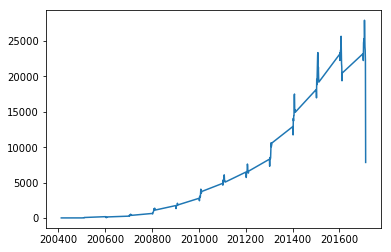

In [9]:
# Distribution of dates
date_X = [t[0] for t in sortedDates]
date_Y = [t[1] for t in sortedDates]

plt.plot(date_X, date_Y)
plt.show()

In [10]:
# Clean out data before 201501
quad = int(len(sortedDates)/4)
mid = int(len(sortedDates)/2)
data_since_2015 = sortedDates[quad+mid+3:]

In [11]:
# Number of data since 2015
total = 0
for tup in data_since_2015:
    total += tup[1]
    
total

791375

In order to make the most relevant prediction, we thus decided to only keep data after January 2015.

# 2. Cleaning the data
### Here we decide to clean the data again, keeping only reviews with two or more votes after January 2015.

## 2.1 Clean the data by date


In [12]:
dateDict = {}
for tup in data_since_2015:
    date = tup[0]
    freq = tup[1]
    if date not in dateDict:
        dateDict[date] = freq

In [13]:
def process_data_by_date(dataset):
    new = []
    for d in dataset:
        dateList = d["date"].split("-")
        date = dateList[0] + dateList[1]
        if date in dateDict:
            new.append(d)
    return new

In [14]:
newer_useful = process_data_by_date(useful)
newer_useless = process_data_by_date(useless)
print(len(newer_useful), len(newer_useless))

341882 449493


## 2.2 Clean the useful data by votes

In [15]:
def process_data_by_vote(dataset):
    new = []
    for d in dataset:
        if d["useful"] >= 2:
            new.append(d)
    return new

In [16]:
more_useful = process_data_by_vote(newer_useful)
len(more_useful)

123477

To maintain equal number of training/testing data from two categories, we decided to keep only 123477 useless data as well.We pick the first 123477 data after shuffling

In [17]:
from random import shuffle
shuffle(newer_useless)
more_useless = newer_useless[:123477]
print(len(more_useful), len(more_useless))

123477 123477


# 3. Finding features and training the model

## 3.1 Find the words with highest frequencies

In [18]:
import re
from collections import Counter
import nltk
from nltk import word_tokenize

In [19]:
nonPunct = re.compile('.*[A-Za-z0-9].*')

In [20]:
# Count punctuation in text of each data
def text_count_punctuations(sentence):
    tokens = word_tokenize(sentence)
    punc = [w for w in tokens if not nonPunct.match(w)]
    exc = [w for w in punc if w == "!"]
    return (len(punc), len(exc))

def count_punctuations(dataset):
    for d in dataset:
        text = d["text"]
        num_punc, num_exc = text_count_punctuations(text)
        if "punctuations" not in d:
            d["punctuations"] = num_punc
        if "exclamations" not in d:
            d["exclamations"] = num_exc
    return dataset

useful_with_punc = count_punctuations(more_useful)
useless_with_punc = count_punctuations(more_useless)

In [21]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stop_words_and_punc(sentence):
    word_tokens = word_tokenize(sentence.lower())
    filtered_sentence = [w for w in word_tokens if not w in stop_words and nonPunct.match(w)]
    return filtered_sentence

In [22]:
# Find words with highest frequencies in both "useful" and "useless" dataset
from nltk.probability import FreqDist

def high_freq_words(dataset):
    texts = []
    for d in dataset:
        noStopAndPunc = remove_stop_words_and_punc(d["text"])
        texts += noStopAndPunc
    fdist = FreqDist(texts)
    return fdist

In [24]:
fdist_useful = high_freq_words(useful_with_punc)
fdist_useful.most_common(500)

[('food', 74884),
 ('place', 58019),
 ("n't", 55829),
 ('good', 54540),
 ("'s", 47263),
 ('great', 45809),
 ('service', 42190),
 ('back', 28809),
 ('like', 26668),
 ('time', 25181),
 ('get', 23357),
 ('go', 22925),
 ('one', 22412),
 ('really', 21608),
 ('would', 21333),
 ('chicken', 19527),
 ('ordered', 17887),
 ('best', 17874),
 ('delicious', 17857),
 ('restaurant', 17019),
 ("'ve", 16829),
 ('also', 16755),
 ('got', 16594),
 ('order', 16400),
 ('nice', 16161),
 ('love', 16062),
 ('try', 16010),
 ('friendly', 15932),
 ('definitely', 15150),
 ('staff', 14903),
 ('pizza', 14762),
 ('come', 14529),
 ('amazing', 14518),
 ('always', 14102),
 ('menu', 13705),
 ('came', 13652),
 ('even', 13464),
 ('us', 13411),
 ('well', 13177),
 ("'m", 12673),
 ('fresh', 12545),
 ('never', 11757),
 ('little', 11205),
 ('lunch', 10853),
 ('better', 10785),
 ('eat', 10399),
 ('wait', 10293),
 ('could', 10179),
 ('pretty', 10133),
 ('first', 10126),
 ('went', 9904),
 ('everything', 9829),
 ('much', 9819),
 ('r

In [25]:
fdist_useless = high_freq_words(useless_with_punc)
fdist_useless.most_common(500)

[('food', 73269),
 ('good', 54699),
 ('great', 54249),
 ('place', 49689),
 ('service', 42025),
 ("n't", 41432),
 ("'s", 35412),
 ('back', 24846),
 ('time', 22867),
 ('go', 20305),
 ('like', 19908),
 ('best', 19270),
 ('delicious', 18774),
 ('really', 18373),
 ('get', 18237),
 ('would', 18132),
 ('one', 17701),
 ('love', 16962),
 ('chicken', 16694),
 ('amazing', 16620),
 ('friendly', 16275),
 ('always', 15964),
 ('nice', 15462),
 ('staff', 15340),
 ('definitely', 15023),
 ('restaurant', 14425),
 ('ordered', 14253),
 ("'ve", 14126),
 ('also', 13739),
 ('order', 13375),
 ('try', 12949),
 ('got', 12924),
 ('pizza', 12409),
 ('come', 11813),
 ('well', 11334),
 ('menu', 11278),
 ('fresh', 11245),
 ('us', 10912),
 ('recommend', 10655),
 ('little', 10241),
 ('came', 10237),
 ('even', 10108),
 ('wait', 9593),
 ('eat', 9493),
 ('lunch', 9316),
 ('excellent', 9286),
 ('first', 9126),
 ("'m", 8946),
 ('better', 8891),
 ('went', 8832),
 ('everything', 8742),
 ('never', 8714),
 ('awesome', 8620),
 (

Because the groups of words with highest frequencies of the two sets do not have an obvious difference, we do not include word frequency as a feature in the model

## 3.2 Difference between the rating gives by the review and the overal rating of a business


In [26]:
businesses[0]

{'address': '4855 E Warner Rd, Ste B9',
 'attributes': {'AcceptsInsurance': True,
  'BusinessAcceptsCreditCards': True,
  'ByAppointmentOnly': True},
 'business_id': 'FYWN1wneV18bWNgQjJ2GNg',
 'categories': ['Dentists',
  'General Dentistry',
  'Health & Medical',
  'Oral Surgeons',
  'Cosmetic Dentists',
  'Orthodontists'],
 'city': 'Ahwatukee',
 'hours': {'Friday': '7:30-17:00',
  'Monday': '7:30-17:00',
  'Thursday': '7:30-17:00',
  'Tuesday': '7:30-17:00',
  'Wednesday': '7:30-17:00'},
 'is_open': 1,
 'latitude': 33.3306902,
 'longitude': -111.9785992,
 'name': 'Dental by Design',
 'neighborhood': '',
 'postal_code': '85044',
 'review_count': 22,
 'stars': 4.0,
 'state': 'AZ'}

In [29]:
businessDict = {}
for b in businesses:
    b_id = b["business_id"]
    if b_id not in businessDict:
        businessDict[b_id] = b

In [27]:
# rating_difference = the difference between customer and overall rating * number of votes

def rating_difference(dataset):
    for d in dataset:
        review_stars = d["stars"]
        business = d["business_id"]
        if business in businessDict:
            b_stars = businessDict[business]["stars"]
            difference = (review_stars - b_stars)
            if difference not in d:
                d["rating_difference"] = difference
            if "b_stars" not in d:
                d["b_stars"] = b_stars

In [30]:
# Add rating difference as a feature to all data
rating_difference(useful_with_punc)
rating_difference(useless_with_punc)

In [31]:
# Calculate standard diviation of rating_difference in "useful" and "useless" data
useful_rating_difference = []
for d in useful_with_punc:
    useful_rating_difference.append((d["useful"], d["rating_difference"]))
    
useless_rating_difference = []
for d in useless_with_punc:
    useless_rating_difference.append(d["rating_difference"])
    
useful_std = np.std(useful_rating_difference)
useless_std = np.std(useless_rating_difference)
print(useful_std, useless_std)

3.7218251678 1.21349908822


Because there is a significant difference, we decide to include rating_difference as a feature

## 3.3 Sentiment Analysis

In [32]:
# Import two lists of positive and negative English vocabulary
from negative import *
from positive import *

In [33]:
def num_pos_and_neg(sentence):
    word_tokens = word_tokenize(sentence.lower())
    negation = False
    word_count = 0
    pos = []
    neg = []
    for w in word_tokens:
        
        # mark negation
        if w == "not" or w == "n't":
            negation = True
            word_count += 1
        
        # mark end of sentence
        elif not nonPunct.match(w) or w == "but":
            negation = False
        
        # categorize expression
        elif negation:
            if w in negative_dict:
                pos.append("-"+w)
                negation = False
            elif w in positive_dict:
                neg.append("-"+w)
                negation = False
            word_count += 1
        elif not negation:
            if w in negative_dict:
                neg.append(w)
            elif w in positive_dict:
                pos.append(w)
            word_count += 1
            
    return (len(pos),len(neg),word_count)
                

In [34]:
def pos_and_neg(dataset):
    for d in dataset:
        pos, neg, count = num_pos_and_neg(d["text"])
        if "pos" not in d:
            d["pos"] = pos
        if "word count" not in d:
            d["word count"] = count
        if "neg" not in d:
            d["neg"] = neg

In [35]:
pos_and_neg(useful_with_punc)
pos_and_neg(useless_with_punc)

## 3.4 Extract Features

In [36]:
def get_features(data):
    data["tag"] = "useful" if data["useful"] > 0 else "useless"
    result = {}
    result["rating_difference"] = data["rating_difference"]
    result["word count"] = data["word count"]
    result["punctuations"] = data["punctuations"]
    result["exclamations"] = data["exclamations"]
    result["pos"] = data["pos"]
    result["neg"] = data["neg"]
    return result

In [37]:
get_features(useful_with_punc[0])

{'exclamations': 0,
 'neg': 0,
 'pos': 3,
 'punctuations': 4,
 'rating_difference': 0.5,
 'word count': 44}

## 3.5 Training and Testing

In [39]:
trainData = useful_with_punc[:98781] + useless_with_punc[:98781]
testData = useful_with_punc[98781:] + useless_with_punc[98781:]
shuffle(trainData)
shuffle(testData)

print(len(trainData))
        
print(len(testData))

197562
49392


In [40]:
train = [(get_features(d), d["tag"]) for d in trainData]
test = [(get_features(d), d["tag"]) for d in testData]

### 3.5.1 Using NaiveBayes Classifier in SKLearn

In [41]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import BernoulliNB

In [42]:
BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(train)
print("BernoulliNB accuracy percent:",nltk.classify.accuracy(BNB_classifier, test)*100)

BernoulliNB accuracy percent: 55.86532231940395


### 3.5.2 Using NaiveBayesClassifier in NLTK

In [43]:
clf = nltk.NaiveBayesClassifier.train(train)

In [44]:
nltk.classify.accuracy(clf, test)

0.6135204081632653

In [45]:
clf.show_most_informative_features(5)

Most Informative Features
       rating_difference = 3.5            useles : useful =      7.4 : 1.0
            exclamations = 22             useful : useles =      7.0 : 1.0
                     neg = 12             useful : useles =      5.7 : 1.0
       rating_difference = -4.0           useful : useles =      4.2 : 1.0
            punctuations = 29             useful : useles =      3.7 : 1.0


## 3.6 Predict new reviews

In [46]:
def raw_to_feature(sentence,rating):
    result = {}
    punc, exc = text_count_punctuations(sentence)
    pos, neg, length = num_pos_and_neg(sentence)
    result["punctuations"] = punc
    result["exclamations"] = exc
    result["pos"] = pos
    result["neg"] = neg
    result["word count"] = length
    result["rating_difference"] = rating
    return result

In [47]:
useful_review = "First off, I am going to come back and write a more proper review, but for now this is what you get. I waited a little too long in between coming here to remember exactly what I ordered, but I think I can still get my point across. \nI had a BALL here. It was such a fun and bustling atmosphere. Fantastic food and at really decent prices for such good quality. We had appetizers, pizza, sweet potato ravioli and two drinks each and I am pretty sure it was only $100. I can't wait to come back and try some more of the menu items. \nAlso, at the end of the day the receipt comes with a small notebook where you can write, draw, autograph... whatever you want to encapsulate your time there. It was a really fun, unique little send-off. We had a great time!"
user_rating = 3.0
business_rating = 3.0
features = raw_to_feature(useful_review,user_rating - business_rating)
print("useful", "labeled as:", clf.classify(features))

useful labeled as: useful


In [48]:
useless_review = "I went here for dinner with family (small, 3-person group), and loved it! Waitress was nice, but I will say it took a while to get a second round of drinks. I was able to order a pizza without cheese due to my dairy intolerance. Unbelievable pizza!\nFunky interior, fun outdoor patio, and fun menu. You can pick and choose your own charcuterie board by picking a meat, a cheese, and olives or a spread. I think this is a cool idea, to get drinks with friends and get different charcuterie boards to try. Fun!"
user_rating = 5.0
business_rating = 4.0
features = raw_to_feature(useless_review,user_rating - business_rating)
print("useless", "labeled as:", clf.classify(features))

useless labeled as: useful
